In [430]:
import numpy as np
import random
import matplotlib.pyplot as plt
from lib.gen_utils import *
from lib.lime import *
from PIL import Image
from skimage import color
from Rain_Effect_Generator import RainEffectGenerator
from Snow_Effect_Generator import SnowEffectGenerator

In [431]:
np.random.seed(42)
random.seed(42)

In [432]:
def load_image(image_path):
    image = Image.open(image_path)
    image = np.array(image)
    return image

In [433]:
def show_image(images, titles=None):
    # show image horizontally
    fig, ax = plt.subplots(1, len(images), figsize=(5 * len(images), 5))

    for i, image in enumerate(images):
        if len(image.shape) == 3:
            fig.axes[i].imshow(image)
        else:
            fig.axes[i].imshow(image, cmap="gray")
        if titles:
            fig.axes[i].set_title(titles[i])
    plt.show()

## I. Analytical Methods

---


### Generate Illumination Map


In [434]:
lime = LIME(iterations=23, alpha=1)

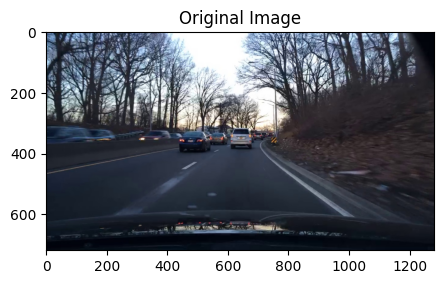

In [435]:
image = load_image("./clear_images/a296eb41-691738fc.jpg")
show_image([image], ["Original Image"])

In [436]:
lime.load(image)
ill_map = lime.illumMap()

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:06<00:00,  3.65it/s]


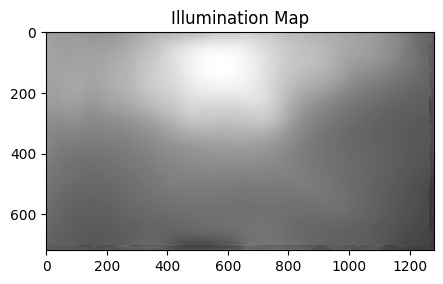

In [437]:
show_image([ill_map], ["Illumination Map"])

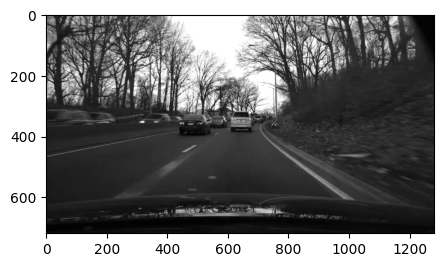

In [438]:
show_image([color.rgb2gray(image)])

In [439]:
HEIGHT = 128
WIDTH = 320

### Generate a Gaussian noise 2D image


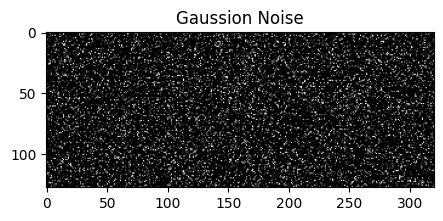

In [440]:
noise = generate_noisy_image(HEIGHT, WIDTH)
show_image([noise], ["Gaussion Noise"])

### Generate rain streak layer by applying 2D matrix convolution K

K is a matrix with the middle horizontal row being all ones and the rest being zeros.

$$
K = \begin{bmatrix}
0 & 0 & \ldots & 0 & 0 \\
0 & 0 & \ldots & 0 & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
1 & 1 & \ldots & 1 & 1 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \ldots & 0 & 0 \\
0 & 0 & \ldots & 0 & 0 \\
\end{bmatrix}


$$


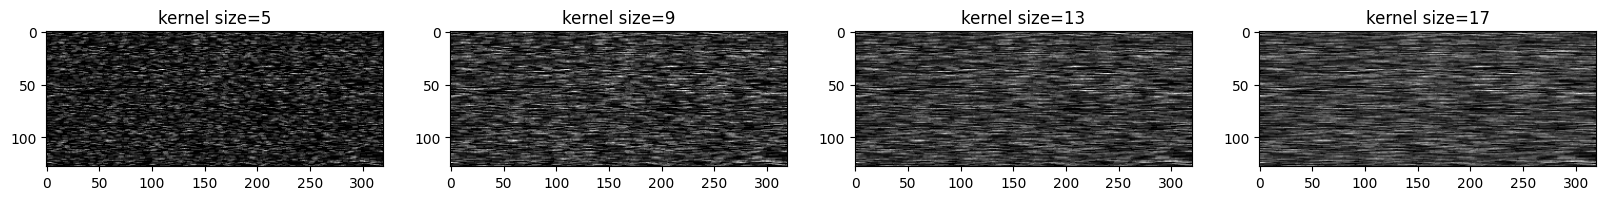

In [441]:
blur_kernels = [5, 9, 13, 17]

blur_noise = [apply_motion_blur_(noise, k) for k in blur_kernels]

show_image(blur_noise, titles=[f"kernel size={k}" for k in blur_kernels])

### Apply rotation matrix to rain streak layer to generate rain streak layer with different angle.


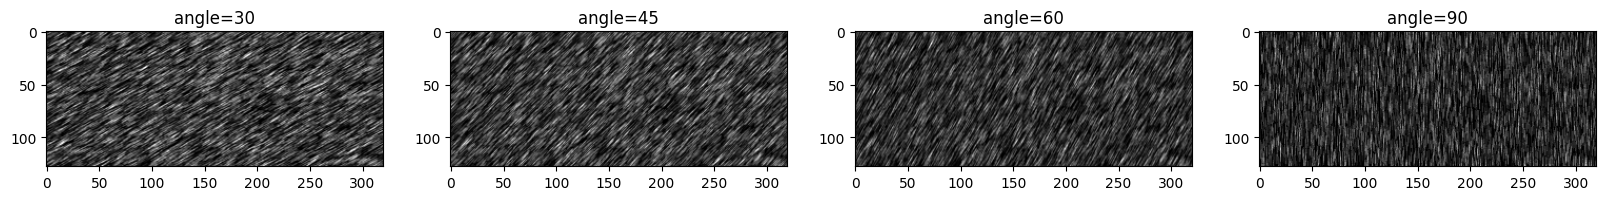

In [442]:
angples = [30, 45, 60, 90]

rotate_noise = [apply_motion_blur(noise, 9, angle=angle) for angle in angples]

show_image(rotate_noise, titles=[f"angle={angle}" for angle in angples])

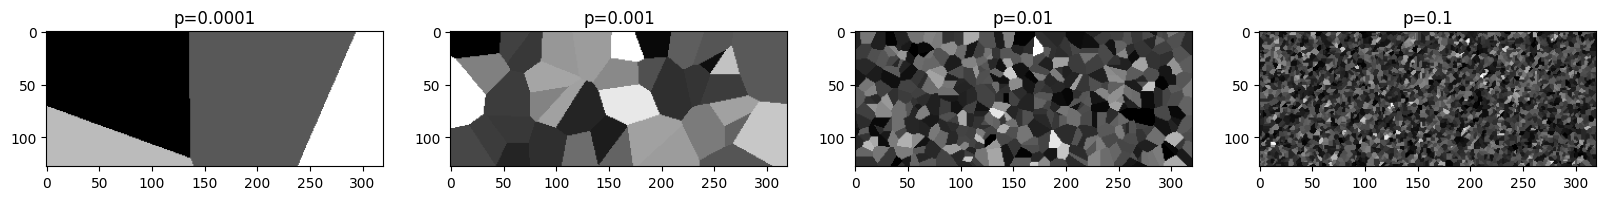

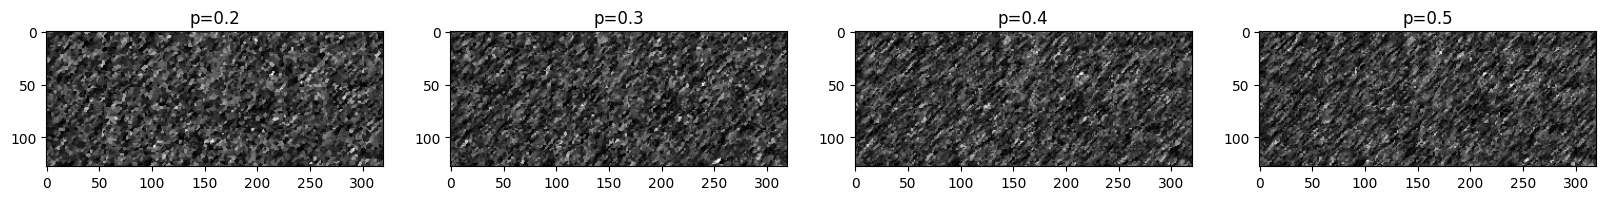

In [443]:
p = [0.0001, 0.001, 0.01, 0.1]
crystallize_noise = [crystallize(rotate_noise[1], amount) for amount in p]
show_image(crystallize_noise, titles=[f"p={amount}" for amount in p])

p = [0.2, 0.3, 0.4, 0.5]
crystallize_noise = [crystallize(rotate_noise[1], amount) for amount in p]
show_image(crystallize_noise, titles=[f"p={amount}" for amount in p])

### Rescale rain streak layer


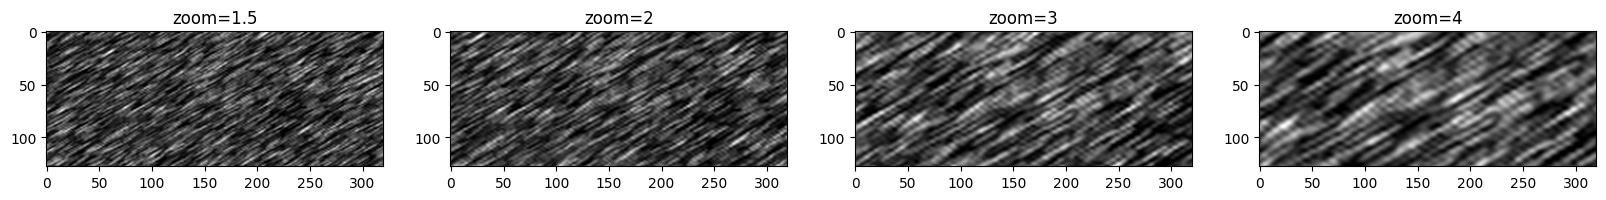

In [444]:
zoom_levels = [1.5, 2, 3, 4]

zoom_noise = [
    zoom_image_and_crop(image=rotate_noise[0], r=level) for level in zoom_levels
]

show_image(zoom_noise, titles=[f"zoom={level}" for level in zoom_levels])

## Generate rain layer by combining multiple layers

Let $R_1, R_2, \ldots, R_n$ be $n$ layers of rain with pixel values in the range $[0, 1]$.

The combined layer $R$:

$$
L = 1 - \prod_{i=1}^{n} (1 - R_i)
$$


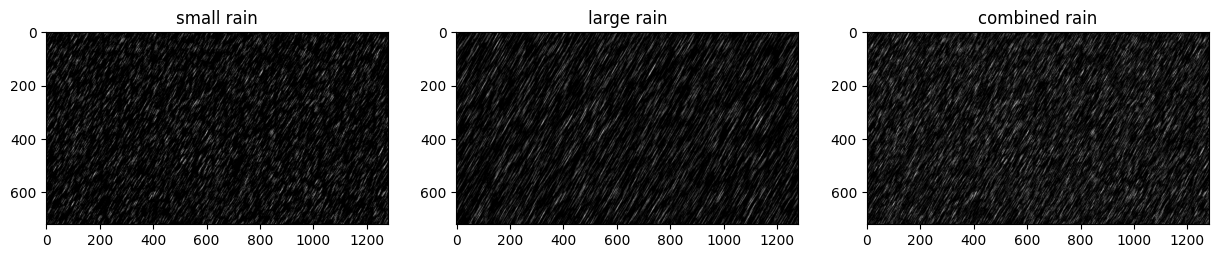

In [445]:
rain_generator = RainEffectGenerator()
ANGLE = 60


large_rain_layer = rain_generator._rain_layer_gen.genRainLayer(
    h=720,
    w=1280,
    blur_kernel_size=23,
    blur_angle=ANGLE,
)  # large

small_rain_layer = rain_generator._rain_layer_gen.genRainLayer(
    h=720,
    w=1280,
    blur_kernel_size=11,
    blur_angle=ANGLE,
)  # small

rain_layer = layer_blend(small_rain_layer, large_rain_layer)

show_image(
    [small_rain_layer, large_rain_layer, rain_layer],
    ["small rain", "large rain", "combined rain"],
)

## Generate snow layer by combining multiple layers

Let $S_1, S_2, \ldots, S_n$ be $n$ layers of snow with pixel values in the range $[0, 1]$.

The combined layer $L$:

$$

L = 1 - \prod_{i=1}^{n} (1 - S_i)


$$


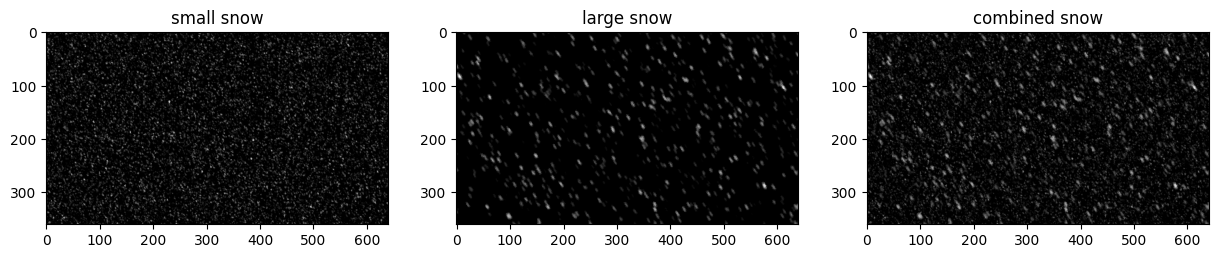

In [446]:
snow_generator = SnowEffectGenerator()
ANGLE = 60


large_snow_layer = snow_generator._snow_layer_gen.genSnowMultiLayer(
    h=360,
    w=640,
    intensity="large",
    blur_angle=ANGLE,
)  # large

small_snow_layer = snow_generator._snow_layer_gen.genSnowMultiLayer(
    h=360,
    w=640,
    intensity="small",
    blur_angle=ANGLE,
)  # small

snow_layer = layer_blend(small_snow_layer, large_snow_layer)

show_image(
    [small_snow_layer, large_snow_layer, snow_layer],
    ["small snow", "large snow", "combined snow"],
)